In [34]:
%%writefile /home/melinda_yang/ivpp/bronzeage/slatkin_getgenocounts.py

import numpy as np
import random

pD="/home/melinda_yang/ivpp/bronzeage/"
fh="ind_A_v13_TBH"
subsetind=".single"

anc=["Zhougongmiao","XianShang_R2142","XianShang_R2148",
    "Linzi_R2038", "Linzi_R2039","Linzi_R2099","Tonglin",
    "Balikun","DHG_M11","DHG_M12","DHG_M819","DHG_M820","DHG_M827","DHG_M9JM6"]

dhg=["DHG_M11","DHG_M12","DHG_M819","DHG_M820","DHG_M827","DHG_M9JM6"]
linzi=["Linzi_R2038", "Linzi_R2039","Linzi_R2099"]
xshang=["XianShang_R2142","XianShang_R2148"]
africans=["Yoruba","Mbuti","Mandenka","Ju_hoan_North"]
myanc,ancname=(linzi,"LZ")
myanc,ancname=(xshang,"XS.pdEUR")
#myanc=linzi
##French, Sardinian, Italian_North
myhans=["HGDP00511","HGDP00539","HGDP00665","HGDP01079","HGDP01147","HGDP01177"]
#myhans=["HGDP00774","A_Han-4","GN01","T_Tibetan-1","S_Miao-1","HGDP01189","S_Dai-1",
#        "S_Cambodian-1","S_Korean-2","S_Japanese-3","S_Yi-2","S_Naxi-1","S_Ami-2","S_Lahu-1"]
ancind,afrind=[],[]
easinds=[]
indfile=open(pD+fh+subsetind+".ind",'r')
for ind,line in enumerate(indfile):
    x = line.split()
    if x[2] in myanc: ancind.append(ind)
    if x[2] in africans: afrind.append(ind)
    if x[0] in myhans: easinds.append(ind)
indfile.close()

num=0
fixedafr=0
ptype=[[0,0,0] for i in easinds]
genofile=open(pD+fh+".geno",'r')
for ind,line in enumerate(genofile):
    if ind%10000==0: print ind
    afralleles=set([geno for base,geno in enumerate(line) if base in afrind and geno != '9'])
    if len(afralleles) == 1: fixedafr+=1; continue
    ancalleles=[geno for base,geno in enumerate(line) if base in ancind and geno != '9']
    
    #print ancalleles
    if len(ancalleles)<2: continue
    elif len(ancalleles)==2: ancalleles=''.join(ancalleles)
    else: ancalleles=''.join(random.sample(ancalleles,2))
    for ind2,easind in enumerate(easinds): 
        easgeno=line[easind]
        if easgeno == '9': continue
        elif easgeno == '0': easallele='0'
        elif easgeno == '1': easallele=random.choice(['0','2'])
        elif easgeno == '2': easallele='2'
        else: "easgeno??", easgeno
        #print easallele, ancalleles
        allalleles=easallele+ancalleles
        if allalleles in ['000','222']: ptype[ind2][0]+=1
        elif allalleles in ['022','200']: ptype[ind2][2]+=1
        elif allalleles in ['002','202','020','220']: ptype[ind2][1]+=1
        else: print 'whaaa', allalleles; break
    num+=1
    #if num==1000: break

ptype=np.array(ptype)
#print ptype
#np.savetxt(pD+"sda_"+fh+".XS.genos",ptype)
#print ptype
#for myrow in range(ptype.shape[0]):
#    my0 = (ptype[myrow,:]==0).sum()
#    my1 = (ptype[myrow,:]==1).sum()
#    my2 = (ptype[myrow,:]==2).sum()
#    if myrow==0: mysets=np.array([my0,my1,my2])
#    else: mysets=np.vstack((mysets,np.array([my0,my1,my2])))
#print mysets
mycomments="anc:"+','.join(myanc)+'\npd:'+','.join(myhans)
np.savetxt(pD+"sda_"+fh+"."+ancname+".genocount",ptype,fmt="%i",header=mycomments,comments="#")
#pcounts=[[ptypeone.count(i) for i in set(ptypeone)] for ptypeone in ptype]
#newfile=open(pD+"sda_"+fh+".XS.genocount",'w')
#for ind,ptype in enumerate(pcounts): 
#    newfile.write(myhans[ind]+'\t'+'\t'.join([str(i) for i in ptype]+'\n'))
#newfile.close()
genofile.close()

Overwriting /home/melinda_yang/ivpp/bronzeage/slatkin_getgenocounts.py


In [12]:
import numpy as np
np.savetxt??

In [35]:
print [ptype.count(i) for i in set(ptype)]

[14770, 5097, 2764]


In [9]:
import random
x=[2,1,2]
print random.shuffle(x)
print x

None
[1, 2, 2]


In [32]:
import scipy.optimize as op
from scipy.special import gammaln
import numpy as np
import random
from lmfit import minimize, Parameters
reps=range(1000)
xs=[14770, 5097, 2764]
xs=[13306, 4927, 2642]
pD="/home/melinda_yang/ivpp/bronzeage/sda/"
fh="sda_ind_A_v13_TBH.XS"
mycountsary=np.loadtxt(pD+fh+".genocount")
mycountsfile=open(pD+fh+".genocount",'r')
c1=mycountsfile.readline().strip().split(':')[1].split(',')
c2=mycountsfile.readline().strip().split(':')[1].split(',')
mycountsfile.close()
##ptype is vector of a/aa, A/AA (p0), a/Aa, A/Aa, a/aA, A/aA (p1) and a/AA, A/aa (p2)
def log_factorial(x):
    """Returns the logarithm of x!
    Also accepts lists and NumPy arrays in place of x."""
    return gammaln(np.array(x)+1)

def lnlik(varyparams,n0,n1,n2):
    c=varyparams['c']
    k1=varyparams['k1']
    #print c, k1
    counts=np.array([n0,n1,n2])
    k0=1.0-k1
    p0=k0+k1/3.0
    p1=(2/3.0)*(1-c)*k1
    p2=(k1/3.0)*(c+1)
    ps=np.array([p0,p1,p2])
    ##didn't add factorial parts because not varying
    result = counts * np.log(ps)
    return result

for indpd,mypd in enumerate(c2):
    print mypd
    xs=list(mycountsary[indpd,:])
    for ind,rep in enumerate(reps):
        #print '-----------'+str(rep)+'------------'
        params=Parameters()
        params.add('c',value=random.uniform(0,1),min=0,max=1)
        params.add('k1',value=random.uniform(0,1),min=0,max=1)
        mylst=[params['c'].value, params['k1'].value]
        result = minimize(lnlik,params,args=(xs[0],xs[1],xs[2]),method='nelder')
        mylst+=[result.params['c'].value, result.params['k1'].value,result.chisqr]
        #newfile.write(init+'\t'+final+'\t'+"%.4f" % result.chisqr + '\n')
        if ind==0: myresults=np.array(mylst)
        else: myresults=np.vstack((myresults,np.array(mylst)))
    np.savetxt(pD+fh+".pd"+mypd+".reps",myresults,fmt="%.4e",comments="#",header="c_init,k1_init,c_final,k1_final,chisqr") 

HGDP00774
A_Han-4
GN01
T_Tibetan-1
S_Miao-1
HGDP01189
S_Dai-1
S_Cambodian-1
S_Korean-2
S_Japanese-3
S_Yi-2
S_Naxi-1
S_Ami-2
S_Lahu-1


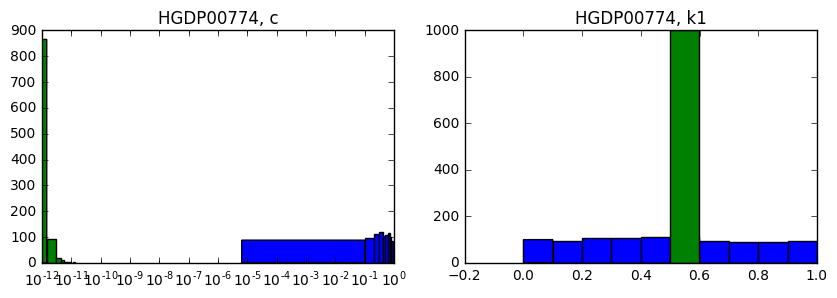

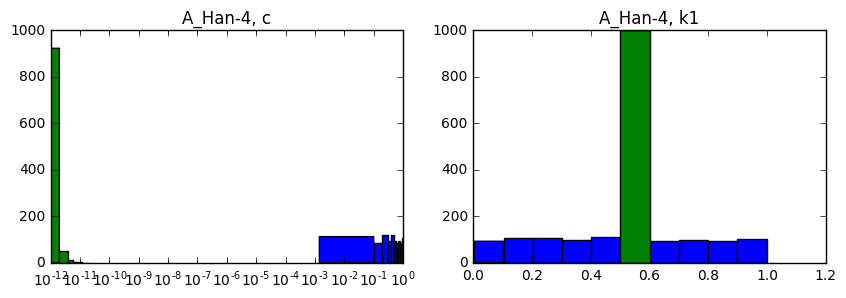

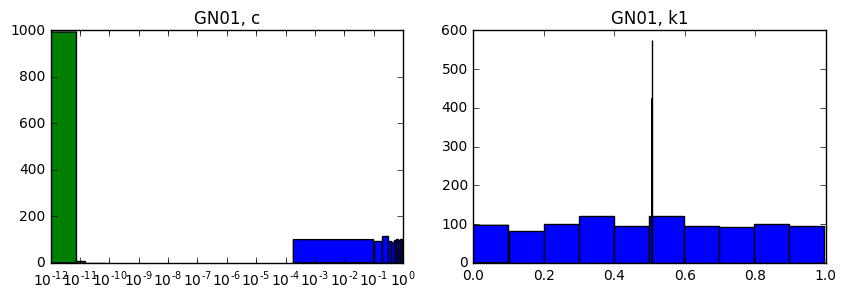

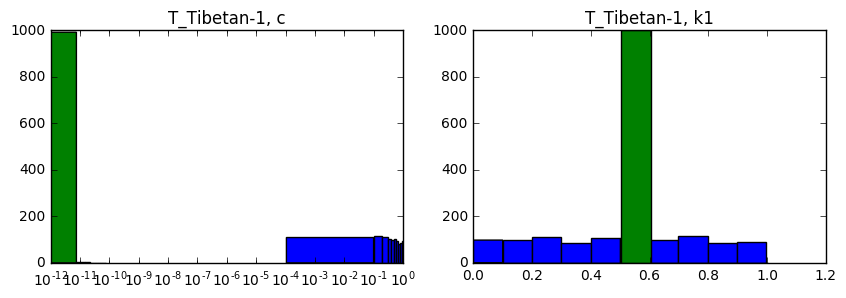

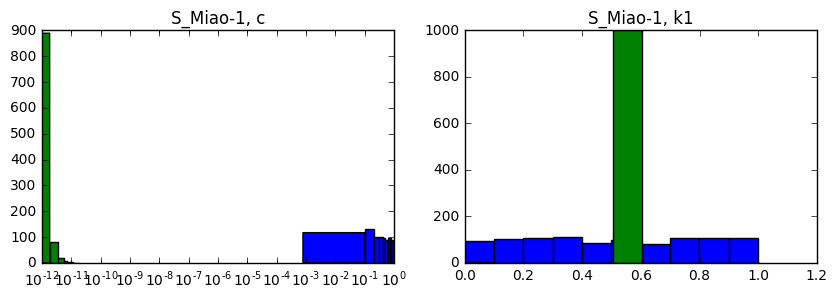

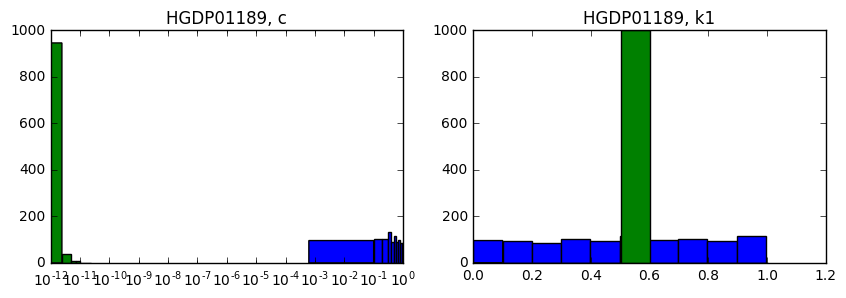

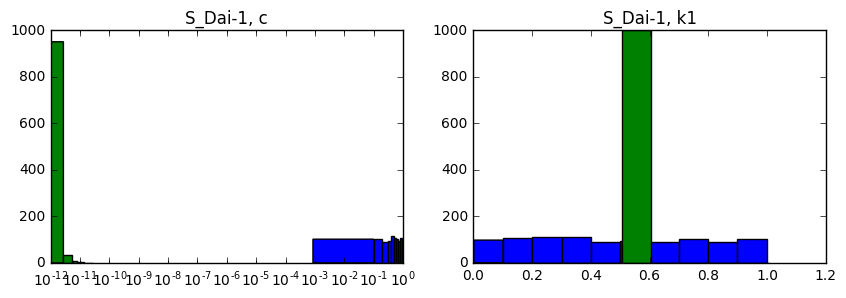

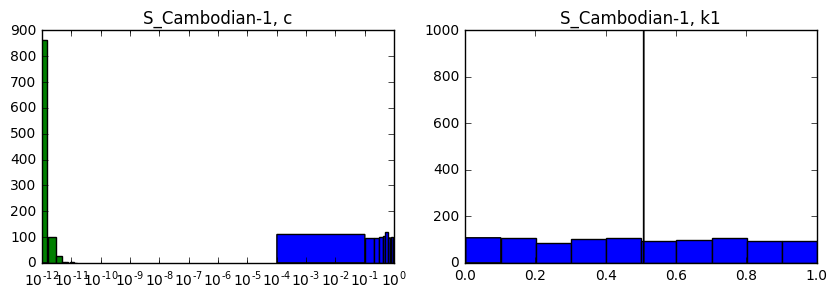

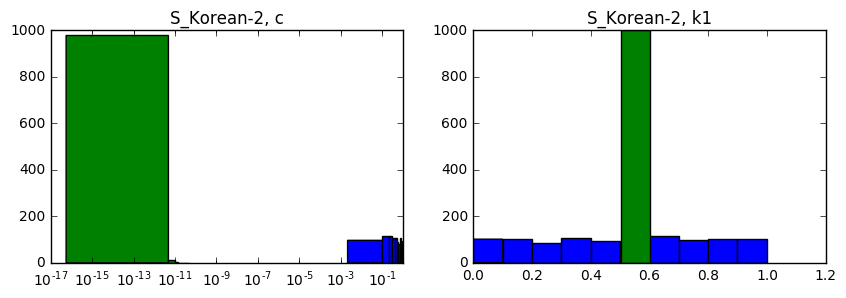

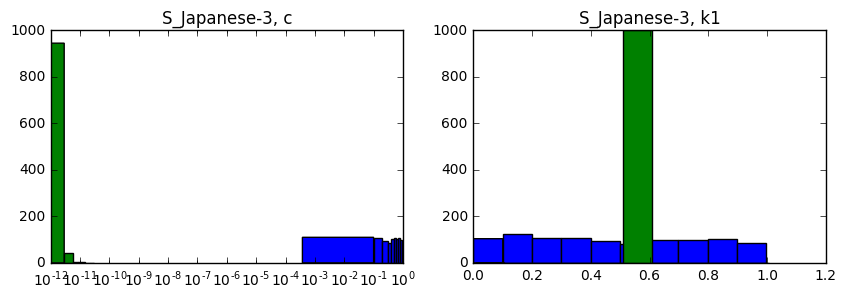

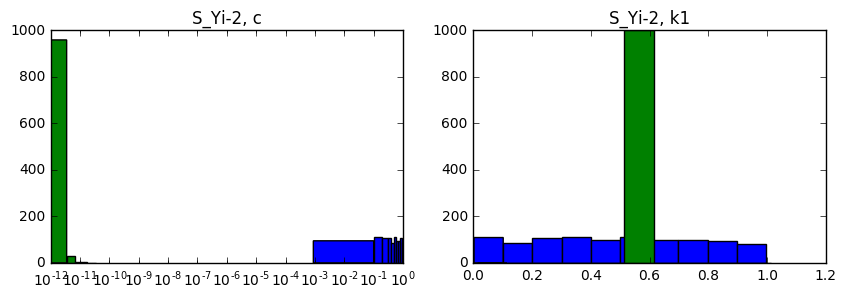

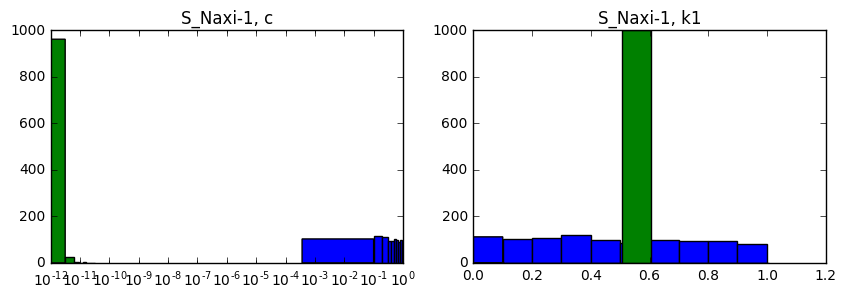

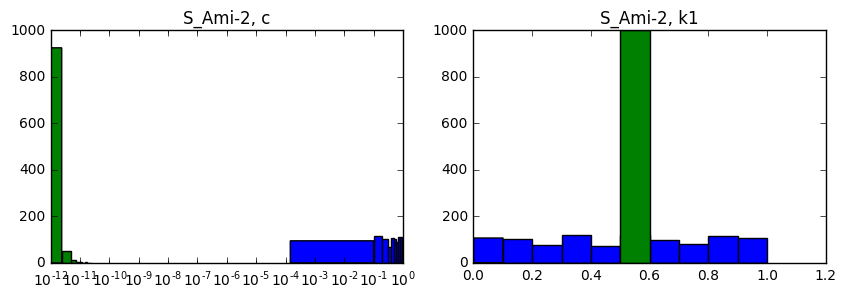

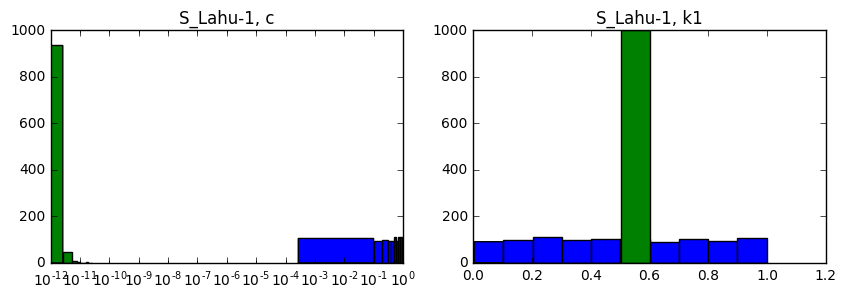

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
pD="/home/melinda_yang/ivpp/bronzeage/sda/"
fh="sda_ind_A_v13_TBH.XS"
mycountsary=np.loadtxt(pD+fh+".genocount")
mycountsfile=open(pD+fh+".genocount",'r')
c1=mycountsfile.readline().strip().split(':')[1].split(',')
c2=mycountsfile.readline().strip().split(':')[1].split(',')
mycountsfile.close()
for indpd,mypd in enumerate(c2):
    #print mypd[:-1]
    myresults=np.loadtxt(pD+fh+".pd"+mypd+".reps")
    #print myresults
    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.hist(myresults[:,0])
    ax1.hist(myresults[:,2])
    ax1.set_xscale('log')
    ax1.set_title('%s, c' % mypd)
    ax2.hist(myresults[:,1])
    ax2.hist(myresults[:,3])
    #ax2.set_xscale('log')
    ax2.set_title('%s, k1' % mypd)
    #print 